In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.applications import MobileNetV3Small

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


2022-03-13 18:56:40.869420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 18:56:40.869449: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
train_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/train"
test_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/test"



In [7]:
# No preprocess function is passed because mobileNetV3 has it builtIn 

train_batches  = ImageDataGenerator().flow_from_directory(train_path,target_size=[64,64],batch_size=30)
test_batches  = ImageDataGenerator().flow_from_directory(test_path,target_size=[64,64],batch_size=20)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Building the model

In [8]:
base_model = MobileNetV3Small(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=preds)

2022-03-13 19:00:17.379571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 19:00:17.379632: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 19:00:17.379668: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-03-13 19:00:17.380033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4349952/4334752 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

# Freezing the non training layers

In [10]:
for layers in model.layers[:-5]:
     layers.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

# Compiling and Fitting the model

In [11]:
epochs = 20 # final

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model.fit(train_batches,validation_data=test_batches,epochs=epochs)


Epoch 1/20
80/80 [==============================] - 10s 87ms/step - loss: 0.6337 - accuracy: 0.6988 - val_loss: 0.5521 - val_accuracy: 0.7867
Epoch 2/20
80/80 [==============================] - 6s 72ms/step - loss: 0.4776 - accuracy: 0.8138 - val_loss: 0.4099 - val_accuracy: 0.8233
Epoch 3/20
80/80 [==============================] - 6s 73ms/step - loss: 0.3735 - accuracy: 0.8508 - val_loss: 0.3426 - val_accuracy: 0.8533
Epoch 4/20
80/80 [==============================] - 6s 72ms/step - loss: 0.3160 - accuracy: 0.8850 - val_loss: 0.3053 - val_accuracy: 0.8717
Epoch 5/20
80/80 [==============================] - 6s 73ms/step - loss: 0.2748 - accuracy: 0.9025 - val_loss: 0.2761 - val_accuracy: 0.8883
Epoch 6/20
80/80 [==============================] - 6s 72ms/step - loss: 0.2440 - accuracy: 0.9121 - val_loss: 0.2558 - val_accuracy: 0.8983
Epoch 7/20
80/80 [==============================] - 6s 72ms/step - loss: 0.2175 - accuracy: 0.9287 - val_loss: 0.2362 - val_accuracy: 0.9000
Epoch 8/20
8

In [12]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

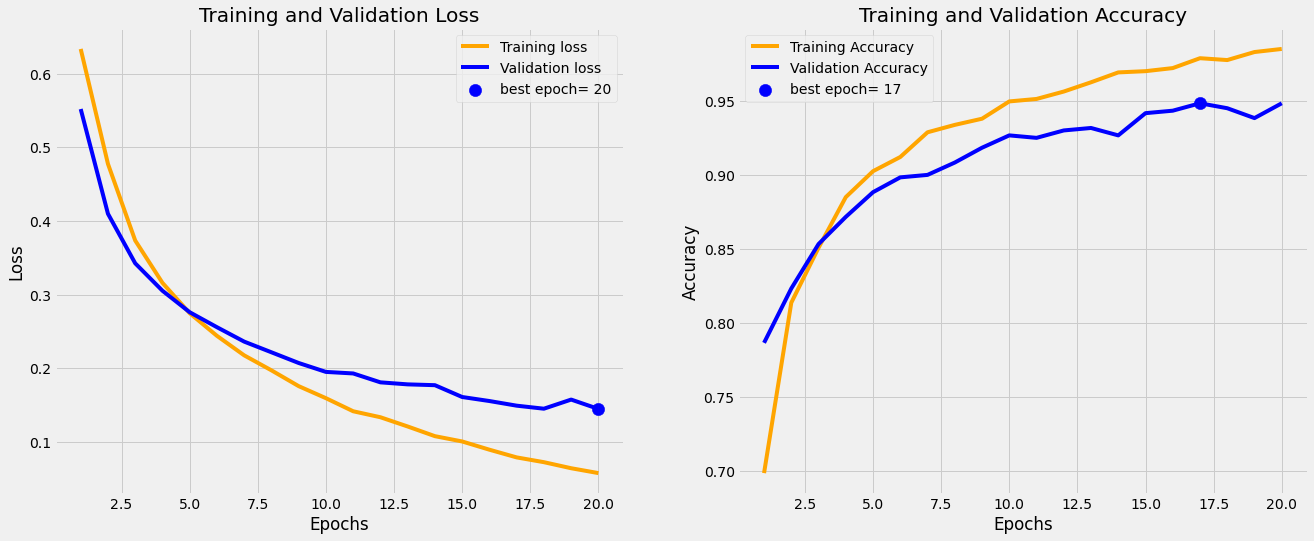

In [15]:
tr_plot(history,0)
plt.savefig('mobileNet_V3_epoch2_20_batch_size_30_final.png')


In [16]:
model.save('BrainTumor_MobileNet_V3SMALL_epochs_20_final.h5')